## 小売店の週平均来店者数を予測する

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

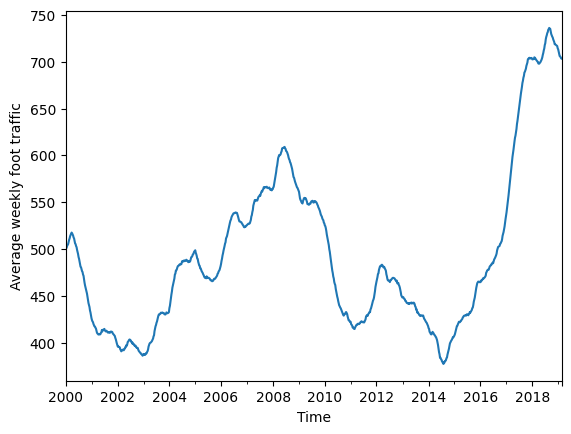

In [12]:
url = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/foot_traffic.csv'
df = pd.read_csv(url)
df.index = pd.date_range('2000-01-01', freq='W', periods=1000, name='Time')

# plot
fig, ax = plt.subplots()
ax.set_ylabel('Average weekly foot traffic')
df['foot_traffic'].plot()
plt.show()

## 自己回帰プロセス(AR)を定義する

## 定常的なARプロセスの次数を特定する

平均来店者数ADF検定
ADF Statistic: -1.176
p-value: 0.684
平均来店者数(1次差分) ADF検定
ADF Statistic: -5.268
p-value: 0.000


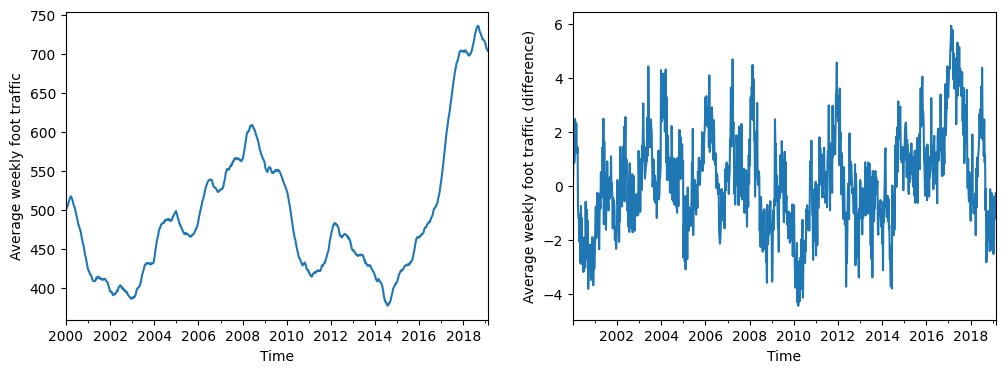

In [22]:
ADF_result = adfuller(df['foot_traffic'])
print('平均来店者数ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

df_diff = df.diff().dropna()
ADF_result = adfuller(df_diff['foot_traffic'])
print('平均来店者数(1次差分) ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

fig, axes = plt.subplots(1, 2, figsize=[12, 4])
df['foot_traffic'].plot(ax=axes[0])
df_diff['foot_traffic'].plot(ax=axes[1])
axes[0].set_ylabel('Average weekly foot traffic')
axes[1].set_ylabel('Average weekly foot traffic (difference)')
plt.show()

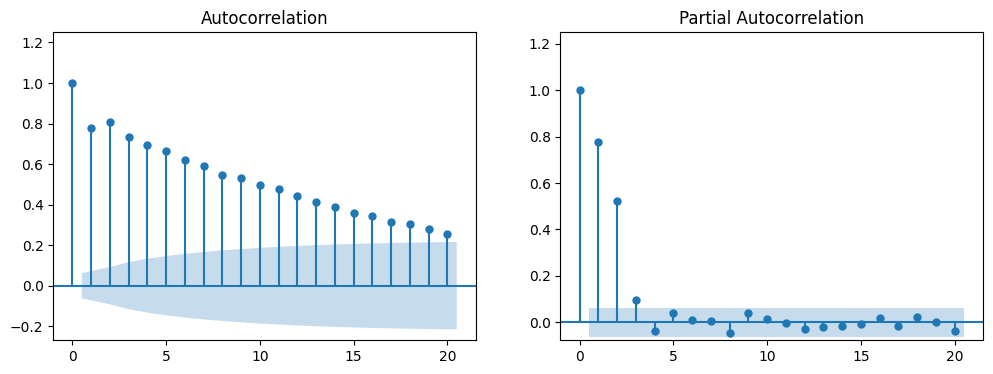

In [23]:
fig, axes = plt.subplots(1, 2, figsize=[12, 4])
plot_acf(df_diff, auto_ylims=True, lags=20, ax=axes[0])
plot_pacf(df_diff, auto_ylims=True, lags=20, ax=axes[1])
plt.show()

## ARプロセスを予測する

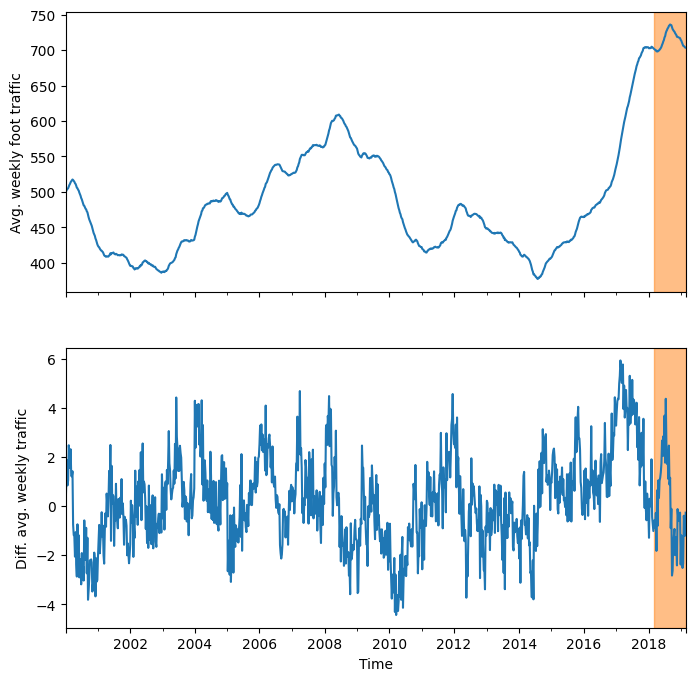

In [24]:
train = df_diff[:-52]
test = df_diff[-52:]

fig, axes = plt.subplots(2, 1, figsize=[8, 8], sharex=True)
df['foot_traffic'].plot(ax=axes[0])
df_diff['foot_traffic'].plot(ax=axes[1])
axes[0].set_ylabel('Avg. weekly foot traffic')
axes[1].set_ylabel('Diff. avg. weekly traffic')
for i in range(2):
    axes[i].axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)

In [28]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window :int, method: str) -> list:
    total_len = train_len + horizon
    preds = []
    if method == 'mean':
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            preds.extend(mean for _ in range(window))
    
    elif method == 'last':
        for i in range(train_len, total_len, window):
            last_val = df.iloc[i-1, 0]
            preds.extend(last_val for _ in range(window))
    
    elif method == 'AR':
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3, 0, 0))
            res = model.fit(disp=False)
            pred = res.get_prediction(0, i + window - 1).predicted_mean.iloc[-window:]
            preds.extend(pred)
    else:
        raise ValueError(f"Invalid method: {method}, choose from ['mean', 'last', 'AR']")
    return preds

In [29]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

methods = ['mean', 'last', 'AR']
for method in methods:
    test[method] = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, method)

/tmp/ipykernel_5331/2228618777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[method] = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, method)
/tmp/ipykernel_5331/2228618777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[method] = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, method)


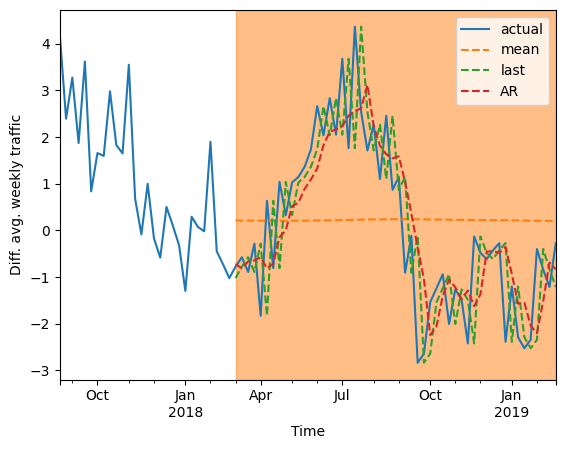

In [31]:
fig, ax = plt.subplots()
df_diff['foot_traffic'].iloc[-80:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
ax.set_ylabel('Diff. avg. weekly traffic')
for method in methods:
    test[method].plot(ax=ax, label=method, ls='dashed')
ax.legend()
plt.show()

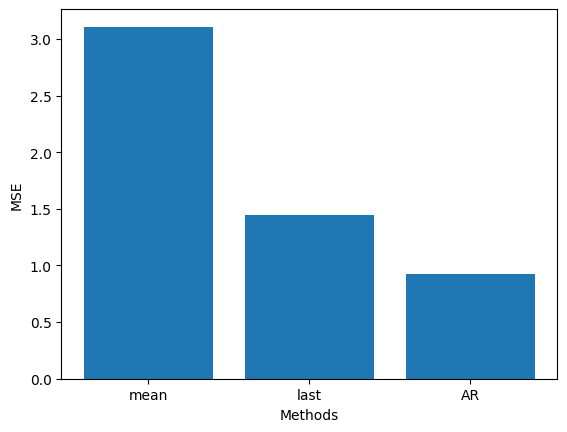

In [33]:
plt.xlabel('Methods')
plt.ylabel('MSE')
plt.bar(
    methods,
    [mean_squared_error(test['foot_traffic'], test[method]) for method in methods]
)
plt.show()

/tmp/ipykernel_5331/3534851149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_AR'].iloc[-52:] = df['foot_traffic'].iloc[-52] + test['AR'].cumsum()


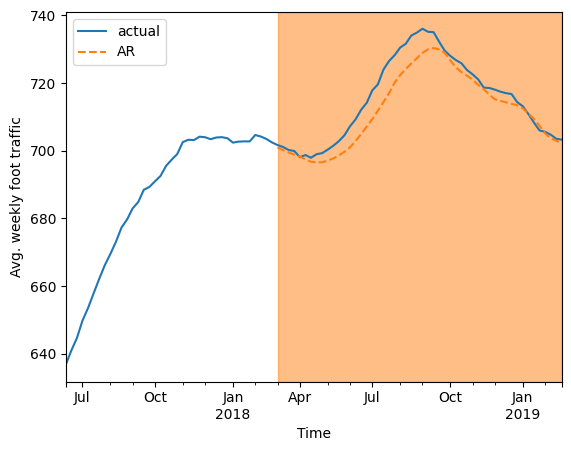

In [34]:
df['pred_AR'] = pd.Series()
df['pred_AR'].iloc[-52:] = df['foot_traffic'].iloc[-52] + test['AR'].cumsum()

# plot
fig, ax = plt.subplots()
df['foot_traffic'].iloc[-90:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
ax.set_ylabel('Avg. weekly foot traffic')
df['pred_AR'].iloc[-90:].plot(ax=ax, label=method, ls='dashed')
ax.legend()
plt.show()

In [35]:
# calculate MAE
print(f"MAE: {mean_absolute_error(df['foot_traffic'].iloc[-52:], df['pred_AR'].iloc[-52:]):.3f}")

MAE: 3.478
